In [34]:
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles,make_moons
import os
import pickle

from src import *

In [2]:
def linear_dataset(n_per_class=250):
    x1_points=np.linspace(-1,1,n_per_class)
    x=np.zeros((2*n_per_class,2))
    y=np.zeros(2*n_per_class)

    for k in range(n_per_class):
        sf_x=np.random.randint(2,10)
        sf_y=np.random.choice(np.arange(2,4))
        x[2*k,:]=[x1_points[k]+(2*np.random.random()-1)/sf_x,0.5+(2*np.random.random()-1)/sf_y]
        x[2*k+1,:]=[x1_points[k]+(2*np.random.random()-1)/sf_x,-0.5+(2*np.random.random()-1)/sf_y]
        y[2*k+1]=1

    for k in range(x.shape[0]):
        if y[k]==1:
            x[k,1]=(x[k,1]-1)/2
        else:
            x[k,1]=(x[k,1]+1)/2
    return x,y,'Linear Dataset'

def vee_dataset(n_per_class=250):
    x_points=np.linspace(-1,1,n_per_class)

    x=np.zeros((2*n_per_class,2))
    y=np.zeros(2*n_per_class)

    for k in range(n_per_class):
        x[2*k,:]=[x_points[k]+(2*np.random.random()-1)/10,np.abs(x_points[k]+(2*np.random.random()-1)/10)]
        x[2*k+1,:]=[x_points[k]+(2*np.random.random()-1)/10,np.abs(x_points[k]+(2*np.random.random()-1)/10)+0.5]
        y[2*k+1]=1
    return x,y,'Vee-Shaped Dataset'

def circles_dataset(n_per_class=250):
    data=make_circles(2*n_per_class,noise=0.05,factor=0.5)
    x=data[0]
    y=data[1]
    return x,y,'Circles Dataset'

def curved_dataset(n_per_class=250):
    data=make_moons(2*n_per_class,noise=0.1)
    x=data[0]
    y=data[1]
    return x,y,'Curved Dataset'

In [87]:
def train_classifier(x,y,lr=1e-3,batch_size=32,epochs=100):

    classifier_model=Classifier(2,16,2)
    classifier_opt=torch.optim.Adam(classifier_model.parameters(),lr=lr)
    classifier_criterion=nn.CrossEntropyLoss()

    y=y.type(torch.int64)

    progress_bar=tqdm(range(epochs))
    for epoch in progress_bar:
        epoch_cycles=x.shape[0]//batch_size
        epoch_loss=0
        for cycle in range(epoch_cycles+1):
            if cycle==epoch_cycles:
                inputs=x[-cycle*batch_size:,:]
                targets=y[-cycle*batch_size:]
            else:
                inputs=x[cycle*batch_size:(cycle+1)*batch_size,:]
                targets=y[cycle*batch_size:(cycle+1)*batch_size]
            classifier_opt.zero_grad()
            outputs=classifier_model(inputs)
            loss=classifier_criterion(outputs,targets.squeeze(1))
            loss.backward()
            classifier_opt.step()
            epoch_loss+=loss*len(targets)
        progress_bar.set_description(f'Training Classifier: epoch {epoch+1}/{epochs}, loss={epoch_loss/x.shape[0]:.4f}')
    return classifier_model

In [4]:
def component_1(x_0,x_1,alpha,lr=1e-3,epochs=20,batch_size=32):
    component_1_ae=AE(x_0.shape[1])
    optimizer=torch.optim.Adam(component_1_ae.parameters(),lr=lr)

    for epoch in range(epochs):
        epoch_cycles=x_1.shape[0]//batch_size
        if x_0.shape[0]%batch_size!=0:
            epoch_cycles+=1
        for k in range(epoch_cycles):
            optimizer.zero_grad()
            if k==epoch_cycles-1:
                batch_data=x_0[k*batch_size:,:]
            else:
                batch_data=x_0[k*batch_size:(k+1)*batch_size,:]
            A_xs=component_1_ae(batch_data)[1]
            f_A_xs=classifier_model(A_xs)
            loss=AutoEncoderLoss(batch_data,A_xs,f_A_xs,1,alpha)
            loss.backward()
            optimizer.step()
    component_1_ae.eval()

    component_1_acc=0
    count=0
    for k in range(x_0.shape[0]):
        if classifier_model(component_1_ae(x_0[k,:])[1].detach())[0].argmax()==1:
            component_1_acc+=1
        count+=1
    component_1_acc/=count

    return component_1_ae,component_1_acc

In [5]:
def component_2(x_0,x_1,alpha,lr=1e-3,epochs=20,batch_size=32):
    component_2_ae=AE(x_0.shape[1])
    optimizer=torch.optim.Adam(component_2_ae.parameters(),lr=lr)

    for epoch in range(epochs):
        epoch_cycles=x_1.shape[0]//batch_size
        if x_1.shape[0]%batch_size!=0:
            epoch_cycles+=1
        for k in range(epoch_cycles):
            optimizer.zero_grad()
            if k==epoch_cycles-1:
                batch_data=x_1[k*batch_size:,:]
            else:
                batch_data=x_1[k*batch_size:(k+1)*batch_size,:]
            A_xs=component_2_ae(batch_data)[1]
            f_A_xs=classifier_model(A_xs)
            loss=AutoEncoderLoss(batch_data,A_xs,f_A_xs,0,alpha)
            loss.backward()
            optimizer.step()
    component_2_ae.eval()

    component_2_acc=0
    count=0
    for k in range(x_1.shape[0]):
        if classifier_model(component_2_ae(x_1[k,:])[1].detach()).argmax()==0:
            component_2_acc+=1
        count+=1
    component_2_acc/=count

    return component_2_ae,component_2_acc

In [97]:
def binary_search(x_0,component_1_ae,component_2_ae,classifier_model,beta=1e-4):
    for n in range(x_0.shape[0]):
        if n==0:
            x_hat_t=component_1_ae(x_0[n,:])[1].detach()
        else:
            x_hat_t=torch.cat([x_hat_t,component_1_ae(x_0[n,:])[1].detach()])
    for n in range(x_hat_t.shape[0]):
        if n==0:
            x_hat_s=component_2_ae(x_hat_t[n,:])[1].detach()
        else:
            x_hat_s=torch.cat([x_hat_s,component_2_ae(x_hat_t[n,:])[1].detach()])

    adversarial_images_0=[]
    classification_0=[]
    pbar=tqdm(range(x_hat_t.shape[0]))
    for k in pbar:
        steps=0
        x_l=x_hat_s[k,:]
        x_r=x_hat_t[k,:]
        if classifier_model(x_l).argmax()==classifier_model(x_r).argmax():
            continue
        while True:
            x_m=(x_l+x_r)/2
            if classifier_model(x_m).argmax()==0:
                x_l=x_m
                steps+=1
            elif classifier_model(x_m).argmax()==1:
                x_r=x_m
                steps+=1
            else:
                break
            if torch.abs(classifier_model(x_m)[0]-classifier_model(x_m)[1])<beta:
                adversarial_images_0.append(x_m)
                classification_0.append(classifier_model(x_m).argmax())
                break

    adversarial_images_1=[]
    classification_1=[]
    pbar=tqdm(range(x_hat_t.shape[0]))
    for k in pbar:
        steps=0
        x_l=x_hat_s[k,:]
        x_r=x_hat_t[k,:]
        if classifier_model(x_l).argmax()==classifier_model(x_r).argmax():
            continue
        while True:
            x_m=(x_l+x_r)/2
            if classifier_model(x_m).argmax()==0:
                x_l=x_m
                steps+=1
            elif classifier_model(x_m).argmax()==1:
                x_r=x_m
                steps+=1
            else:
                break
            if steps>100:
                break
            if torch.abs(classifier_model(x_m)[0]-classifier_model(x_m)[1])<beta:
                adversarial_images_1.append(x_m)
                classification_1.append(classifier_model(x_m).argmax())
                break
    return adversarial_images_0,classification_0,adversarial_images_1,classification_1

In [126]:
x,y,dataset_name=circles_dataset()

x=torch.tensor(x).float()
y=torch.tensor(y).float().unsqueeze(1)

classifier_model=train_classifier(x,y)

x_0=x[(y==0).T[0],:]
x_1=x[(y==1).T[0],:]


for c1_alpha in np.linspace(1,1.1,1):
    component_1_ae,component_1_acc=component_1(x_0,x_1,c1_alpha)
    if component_1_acc>0.95:
        break
print(component_1_acc)

for c2_alpha in np.linspace(1,1.1,1):
    component_2_ae,component_2_acc=component_2(x_0,x_1,c2_alpha)
    if component_2_acc>0.95:
        break
print(component_2_acc)

adversarial_images_0,classification_0,adversarial_images_1,classification_1=binary_search(x_0,component_1_ae,component_2_ae,classifier_model)

Training Classifier: epoch 100/100, loss=0.0042: 100%|██████████| 100/100 [00:03<00:00, 32.21it/s]


1.0
1.0


100%|██████████| 250/250 [00:02<00:00, 94.24it/s] 


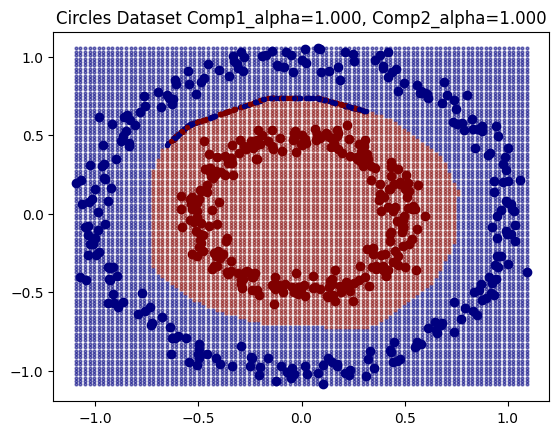

In [127]:
fig,ax=plt.subplots(nrows=1,ncols=1)
colors=plt.cm.jet(np.linspace(0,1,2))

points=[]
decision=[]
for x_cor in np.linspace(min(x[:,0]),max(x[:,0]),100):
    for y_cor in np.linspace(min(x[:,1]),max(x[:,1]),100):
        points.append([x_cor,y_cor])
        decision.append(classifier_model(torch.tensor([x_cor,y_cor]).float()).argmax())
points=np.array(points)
decision=np.array(decision)

ax.scatter(points[decision==0,0],points[decision==0,1],color=colors[0],s=4,alpha=0.5)
ax.scatter(points[decision==1,0],points[decision==1,1],color=colors[1],s=4,alpha=0.5)

ax.scatter(x[(y==0).T[0],0],x[(y==0).T[0],1],color=colors[0])
ax.scatter(x[(y==1).T[0],0],x[(y==1).T[0],1],color=colors[1])

for n,adv_img in enumerate(adversarial_images_0):
    ax.scatter([adv_img[0]],[adv_img[1]],color=colors[classification_0[n]],s=8)
for n,adv_img in enumerate(adversarial_images_1):
    ax.scatter([adv_img[0]],[adv_img[1]],color=colors[classification_1[n]],s=8)

ax.set_title(f'{dataset_name} Comp1_alpha={c1_alpha:.3f}, Comp2_alpha={c2_alpha:.3f}')
#plt.savefig(f'outputs/{dataset_name}_0{str(round(c1_alpha,3)).split('.')[1]}_0{str(round(c2_alpha,3)).split('.')[1]}')
plt.savefig(f'outputs/{dataset_name}_1_1')
plt.show()

In [128]:
def get_edc2(x,y,adversarial_images_0,classification_0,adversarial_images_1,classification_1,lr=1e-2,batch_size=32,epochs=50):
    y=y.float()

    linear_classifier=LinearClassifier(2)
    optimizer=torch.optim.Adam(linear_classifier.parameters(),lr=lr)

    pbar=range(epochs)
    for epoch in pbar:
        epoch_cycles=x.shape[0]//batch_size
        if x.shape[0]%batch_size!=0:
            epoch_cycles+=1
        for k in range(epoch_cycles):
            optimizer.zero_grad()
            if k==epoch_cycles-1:
                batch_data=x[k*batch_size:,:]
                batch_labels=y[k*batch_size:,:]
            else:
                batch_data=x[k*batch_size:(k+1)*batch_size,:]
                batch_labels=y[k*batch_size:(k+1)*batch_size,:]
            optimizer.zero_grad()
            outputs=linear_classifier(batch_data)
            loss=nn.BCELoss()(outputs,batch_labels)
            loss.backward()
            optimizer.step()
    linear_classifier.eval()

    edc2=0
    count=0
    for n,img in enumerate(adversarial_images_0):
        if classification_0[n]==0 and linear_classifier(img)<0.5:
            edc2+=1
        elif classification_0[n]==1 and linear_classifier(img)>0.5:
            edc2+=1
        count+=1

    for n,img in enumerate(adversarial_images_1):
        if classification_1[n]==0 and linear_classifier(img)<0.5:
            edc2+=1
        elif classification_1[n]==1 and linear_classifier(img)>0.5:
            edc2+=1
        count+=1
    return edc2/count

In [129]:
def get_boundary_divergence(adversarial_images_0,adversarial_images_1,iterations=200):
    boundary_points=np.concatenate((adversarial_images_0,adversarial_images_1))
    boundary_similarities=np.zeros(iterations)
    for n in range(iterations):
        img_idxs=np.random.choice(boundary_points.shape[0],size=2,replace=False)
        boundary_1=boundary_points[img_idxs[0],:]-boundary_points[img_idxs[1],:]
        img_idxs=np.random.choice(boundary_points.shape[0],size=2,replace=False)
        boundary_2=boundary_points[img_idxs[0],:]-boundary_points[img_idxs[1],:]
        boundary_similarities[n]=np.abs(np.dot(boundary_1,boundary_2)/(np.linalg.norm(boundary_1)*np.linalg.norm(boundary_2)+1e-8))
    return 1-np.mean(boundary_similarities)

In [130]:
if os.path.exists('outputs/boundary_metrics'):
    boundary_metrics_file=open('outputs/boundary_metrics','rb')
    boundary_metrics=pickle.load(boundary_metrics_file)
    boundary_metrics_file.close()
else:
    boundary_metrics={'edc2':[],'boundary_divergence':[],'datasets':[]}

In [131]:
boundary_metrics['datasets']+=[dataset_name]
edc2=get_edc2(x,y,adversarial_images_0,classification_0,adversarial_images_1,classification_1)
boundary_metrics['edc2']+=[edc2]
boundary_divergence=get_boundary_divergence(adversarial_images_0,adversarial_images_1)
boundary_metrics['boundary_divergence']+=[boundary_divergence]

boundary_metrics_file=open('outputs/boundary_metrics','wb')
pickle.dump(boundary_metrics,boundary_metrics_file)
boundary_metrics_file.close()

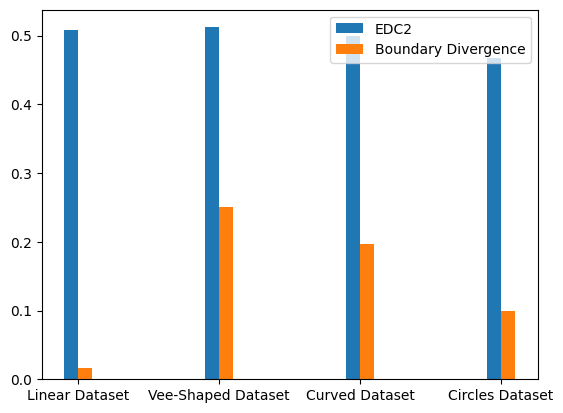

In [132]:
plt.bar(np.arange(len(boundary_metrics['datasets']))-0.05,boundary_metrics['edc2'],width=0.1,label='EDC2')
plt.bar(np.arange(len(boundary_metrics['datasets']))+0.05,boundary_metrics['boundary_divergence'],width=0.1,label='Boundary Divergence')
plt.xticks(np.arange(len(boundary_metrics['datasets'])),boundary_metrics['datasets'])
plt.legend()
plt.savefig('outputs/bar_chart_boundary_metrics.png')
plt.show()